In [ ]:
#Mount our google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
TRAIN_PATH = '/content/drive/MyDrive/data_split/train.csv'
TEST_PATH = '/content/drive/MyDrive/data_split/test.csv'
SAVE_PATH = '/content/drive/MyDrive/LRModel/model.pth'

TEST_SIZE = 0.3
RANDOM_STATE = 128
EPOCHS = 25
BATCH_SIZE = 64
LR = 1e-4

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Running on device: {device}')

Running on device: cuda:0


In [ ]:
class LogisticRegression(nn.Module):
    def __init__(self, D_in=1, D_out=1):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(D_in, D_out)
        
    def forward(self, x):
        y_pred = self.linear(x)

        return y_pred
    
    def predict(self, x):
        result = self.forward(x)

        return torch.sigmoid(result)

In [ ]:
def shuffle_data(X, y):
    assert len(X) == len(y)
    
    p = np.random.permutation(len(X))
    
    return X[p], y[p]

In [ ]:
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv (TEST_PATH)
train_df.head()

,filename,distance,label
0,hnfwagcxdf.mp4,0.587933,1
1,hnfwagcxdf.mp4,1.167863,1
2,hnfwagcxdf.mp4,0.601006,1
3,hnfwagcxdf.mp4,0.606903,1
4,hnfwagcxdf.mp4,0.559757,1


In [ ]:
len(train_df)
len(test_df)

54101

In [ ]:
label_count = train_df.groupby('label').count()['filename']
print(label_count)

# Use pos_weight value to overcome imbalanced dataset.
# https://pytorch.org/docs/stable/nn.html#torch.nn.BCEWithLogitsLoss
pos_weight = torch.ones([1]) * label_count[0]/label_count[1]
print('pos_weight:', pos_weight)

label
0    56561
1    94452
Name: filename, dtype: int64
pos_weight: tensor([0.5988])


In [ ]:
# X = train_df['distance'].to_numpy()
# y = train_df['label'].to_numpy()

In [ ]:
# Not in use as we are using pre-defined split
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)


In [ ]:
X_train = train_df['distance'].to_numpy()
y_train = train_df['label'].to_numpy()

X_val = test_df['distance'].to_numpy()
y_val = test_df['label'].to_numpy()

In [ ]:
X_train = torch.tensor(X_train).to(device).unsqueeze(dim=1).float()
X_val = torch.tensor(X_val).to(device).unsqueeze(dim=1).float()
y_train = torch.tensor(y_train).to(device).unsqueeze(dim=1).float()
y_val = torch.tensor(y_val).to(device).unsqueeze(dim=1).float()

In [ ]:
def compute_accuracy(y_pred, y_true):
    # Convert predictions to binary labels
    y_pred = torch.sigmoid(y_pred)
    y_pred = (y_pred > 0.5).float()

    # Compare with true labels and compute accuracy
    correct = (y_pred == y_true).float()
    accuracy = correct.sum() / len(correct)

    return accuracy.item()


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/2360 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2360 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2360 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/2360 [00:00<?, ?it/s]

  0%|          | 0/2360 [00:00<?, ?it/s]

  0%|          | 0/2360 [00:00<?, ?it/s]

  0%|          | 0/2360 [00:00<?, ?it/s]

  0%|          | 0/2360 [00:00<?, ?it/s]

  0%|          | 0/2360 [00:00<?, ?it/s]

  0%|          | 0/2360 [00:00<?, ?it/s]

  0%|          | 0/2360 [00:00<?, ?it/s]

  0%|          | 0/2360 [00:00<?, ?it/s]

  0%|          | 0/2360 [00:00<?, ?it/s]

  0%|          | 0/2360 [00:00<?, ?it/s]

  0%|          | 0/2360 [00:00<?, ?it/s]

  0%|          | 0/2360 [00:00<?, ?it/s]

  0%|          | 0/2360 [00:00<?, ?it/s]

  0%|          | 0/2360 [00:00<?, ?it/s]

  0%|          | 0/2360 [00:00<?, ?it/s]

  0%|          | 0/2360 [00:00<?, ?it/s]

  0%|          | 0/2360 [00:00<?, ?it/s]

  0%|          | 0/2360 [00:00<?, ?it/s]

  0%|          | 0/2360 [00:00<?, ?it/s]

  0%|          | 0/2360 [00:00<?, ?it/s]

  0%|          | 0/2360 [00:00<?, ?it/s]

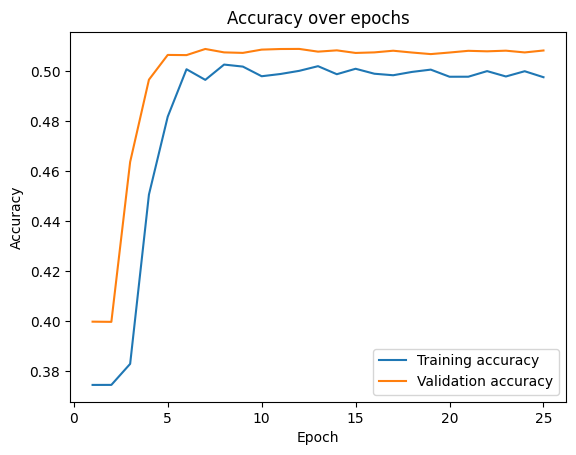

In [ ]:
classifier = LogisticRegression()
classifier = classifier.cuda()
criterion = nn.BCEWithLogitsLoss(reduction='mean', pos_weight=pos_weight) # Improve stability
criterion = criterion.cuda()
optimizer = optim.Adam(classifier.parameters(), lr=LR)

n_batches = np.ceil(len(X_train) / BATCH_SIZE).astype(int)
losses = np.zeros(EPOCHS)
val_losses = np.zeros(EPOCHS)
train_accuracies = np.zeros(EPOCHS)  # Updated variable name
val_accuracies = np.zeros(EPOCHS)  
best_val_loss = 1e7
best_val_acc = 0  # New variable to store the best validation accuracy

for e in tqdm(range(EPOCHS)):
    batch_losses = np.zeros(n_batches)
    batch_accuracies = np.zeros(n_batches)  # Updated variable name
    pbar = tqdm(range(n_batches))
    pbar.desc = f'Epoch {e+1}'
    classifier.train()

    # Shuffle training data
    X_train, y_train = shuffle_data(X_train, y_train)

    for i in pbar:
        # Get batch.
        X_batch = X_train[i*BATCH_SIZE:min(len(X_train), (i+1)*BATCH_SIZE)]
        y_batch = y_train[i*BATCH_SIZE:min(len(y_train), (i+1)*BATCH_SIZE)]

        # Make prediction.
        y_pred = classifier(X_batch)

        # Compute loss.
        loss = criterion(y_pred, y_batch)
        batch_losses[i] = loss

        # Compute accuracy.
        acc = compute_accuracy(y_pred, y_batch)
        batch_accuracies[i] = acc

        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Compute batch loss (average)
    losses[e] = batch_losses.mean()

    # Compute batch accuracy (average)
    train_accuracies[e] = batch_accuracies.mean()  # Updated variable name

    # Compute val loss and accuracy
    classifier.eval()
    y_val_pred = classifier(X_val)
    val_losses[e] = criterion(y_val_pred, y_val)
    val_accuracy = compute_accuracy(y_val_pred, y_val)
    val_accuracies[e] = val_accuracy

    # Save model based on the best (lowest) val loss.
    if val_losses[e] < best_val_loss:
        print('Found a better checkpoint!')
        torch.save(classifier.state_dict(), SAVE_PATH)
        best_val_loss = val_losses[e]

    # Display some information in progress-bar.
    pbar.set_postfix({
        'loss': losses[e],
        'acc': train_accuracies[e],  # Updated variable name
        'val_loss': val_losses[e],
        'val_acc': val_accuracies[e]
    })
        
# Plot the accuracies over epochs
plt.plot(range(1, EPOCHS+1), train_accuracies, label='Training accuracy')
plt.plot(range(1, EPOCHS+1), val_accuracies, label='Validation accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


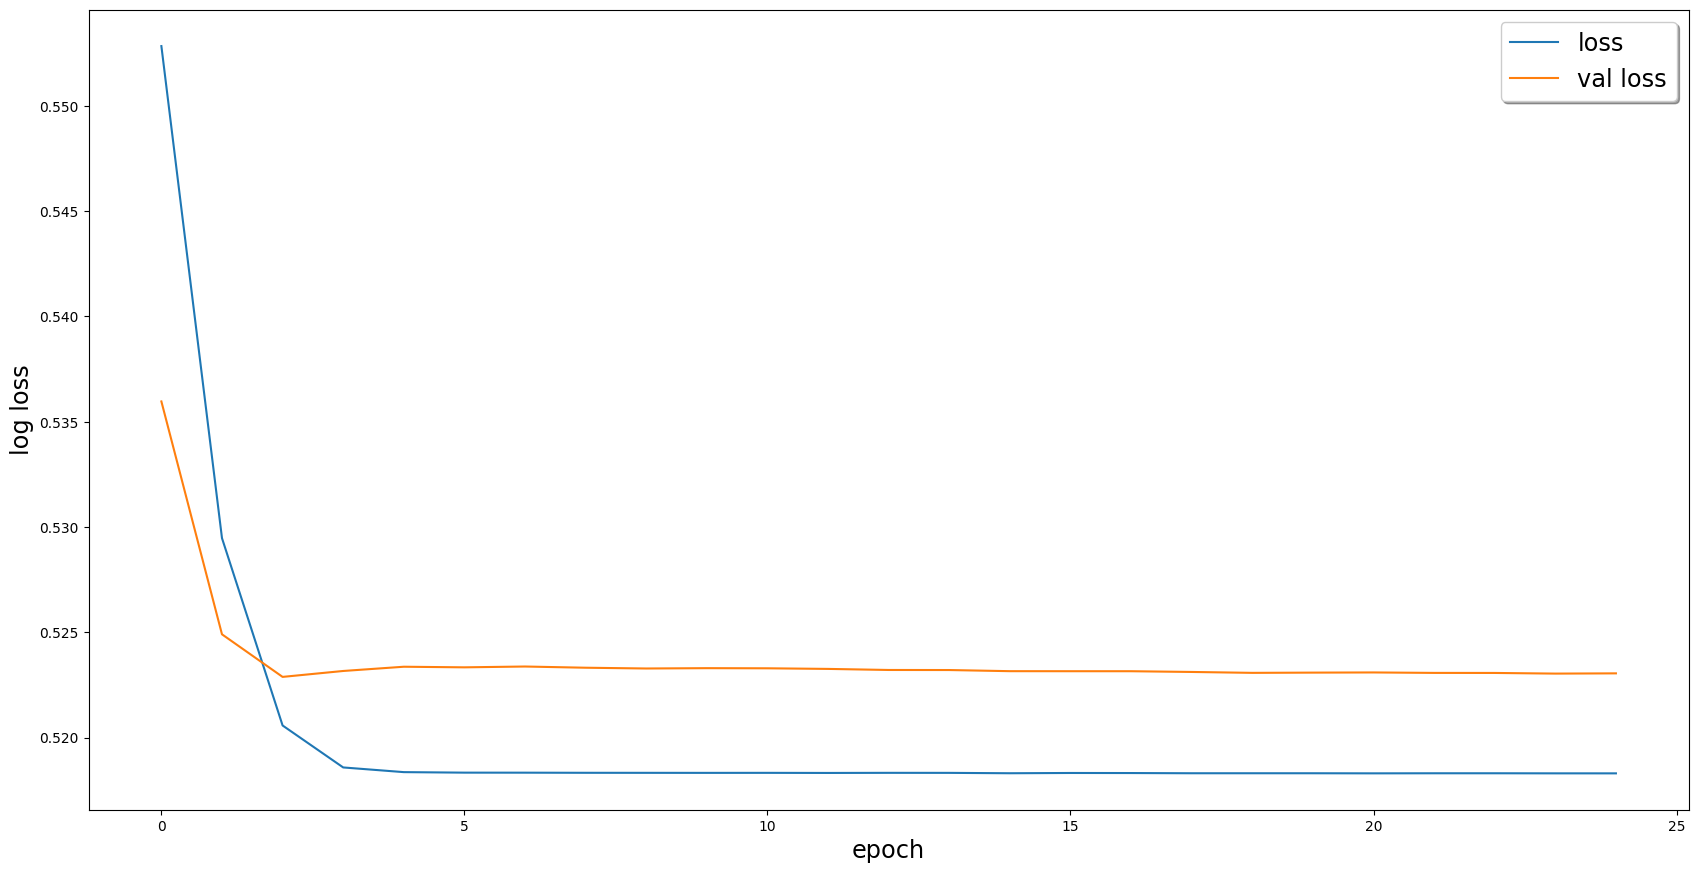

In [ ]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_axes([0, 0, 1, 1])

ax.plot(np.arange(EPOCHS), losses)
ax.plot(np.arange(EPOCHS), val_losses)
ax.set_xlabel('epoch', fontsize='xx-large')
ax.set_ylabel('log loss', fontsize='xx-large')
ax.legend(
    ['loss', 'val loss'],
    loc='upper right',
    fontsize='xx-large',
    shadow=True
)
plt.show()

In [ ]:
without_weight_criterion = nn.BCELoss(reduction='mean')

classifier.eval()
with torch.no_grad():
    y_val_pred = classifier.predict(X_val)
    val_loss = without_weight_criterion(y_val_pred, y_val)

print('val loss:', val_loss.detach().cpu().numpy())

val loss: 0.68988645


[]

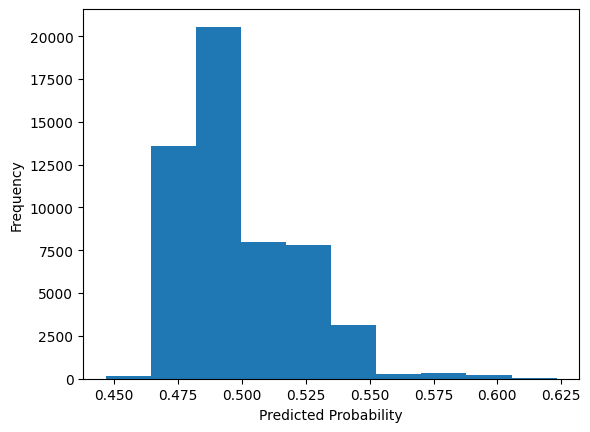

In [ ]:
plt.hist(y_val_pred.squeeze(dim=-1).detach().cpu())

# Add X and Y axis labels
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')


plt.plot()

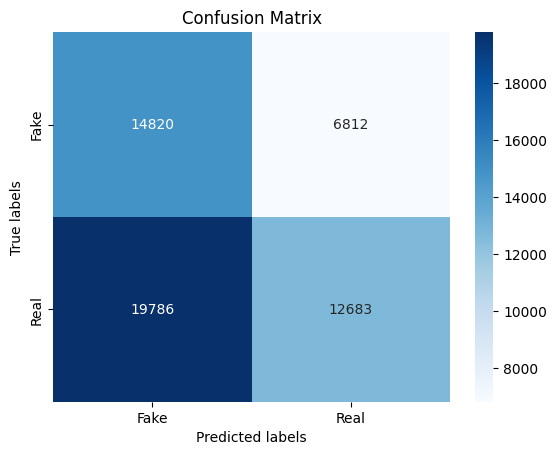

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions on test data
y_pred = classifier.predict(X_val)
y_pred_labels = (y_pred > 0.5).float().cpu().numpy().flatten()
# Compute confusion matrix
conf_mat = confusion_matrix(y_val.cpu().numpy(), y_pred_labels)

# Define the labels to use
labels = ['Fake', 'Real']

# Create a heatmap plot of the confusion matrix
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

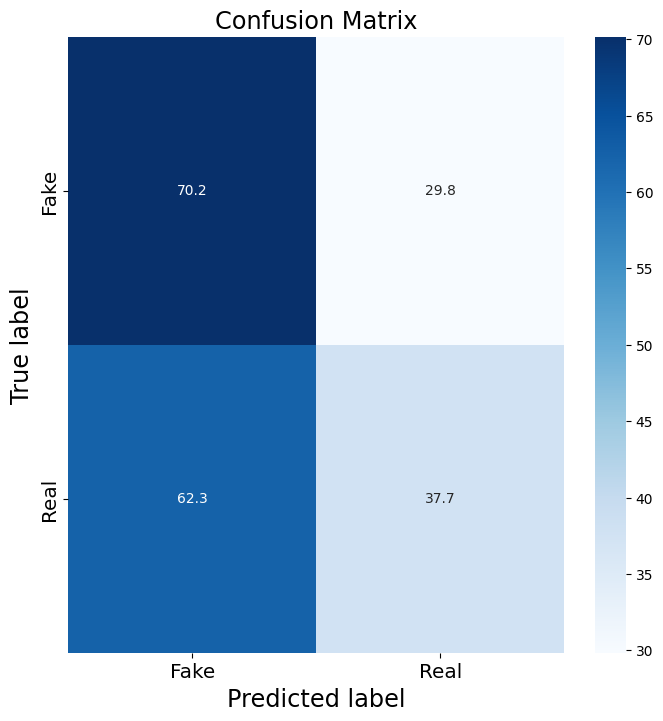

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions on test data
y_pred = classifier.predict(X_val)
y_pred_labels = (y_pred > 0.5).float().cpu().numpy().flatten()

# Compute confusion matrix
cm = confusion_matrix(y_val.cpu(), y_pred_labels)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

labels=["Fake", "Real"]

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues', ax=ax, xticklabels=labels, yticklabels=labels)

# Add labels, title, and ticks
ax.set_xlabel('Predicted label', fontsize='xx-large')
ax.set_ylabel('True label', fontsize='xx-large')
ax.set_title('Confusion Matrix', fontsize='xx-large')
ax.tick_params(axis='both', labelsize='x-large')